In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv()

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

# embedding = HuggingFaceEmbeddings(
#             model_name="../../Embedding/maidalun/bce-embedding-base_v1",
#             model_kwargs={"device": "cuda",
#                           "trust_remote_code": True},
#             encode_kwargs={"normalize_embeddings": True},
#         )

# Stream custom data using .stream / .astream

## Define the graph

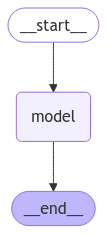

In [2]:
from langchain_core.messages import AIMessage
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.types import StreamWriter


async def my_node(
    state: MessagesState,
    writer: StreamWriter,  # <-- provide StreamWriter to write chunks to be streamed
):
    chunks = [
        "Four",
        "score",
        "and",
        "seven",
        "years",
        "ago",
        "our",
        "fathers",
        "...",
    ]
    for chunk in chunks:
        # write the chunk to be streamed using stream_mode=custom
        writer(chunk)

    return {"messages": [AIMessage(content=" ".join(chunks))]}


# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("model", my_node)
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

app = workflow.compile()

app

## Stream content

In [3]:
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="What are you thinking about?")]
async for chunk in app.astream({"messages": inputs}, stream_mode="custom"):
    print(chunk, flush=True)

Four
score
and
seven
years
ago
our
fathers
...


In [4]:
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="What are you thinking about?")]
async for chunk in app.astream({"messages": inputs}, stream_mode=["custom", "updates"]):
    print(chunk, flush=True)

('custom', 'Four')
('custom', 'score')
('custom', 'and')
('custom', 'seven')
('custom', 'years')
('custom', 'ago')
('custom', 'our')
('custom', 'fathers')
('custom', '...')
('updates', {'model': {'messages': [AIMessage(content='Four score and seven years ago our fathers ...', additional_kwargs={}, response_metadata={})]}})


# Stream custom data using .astream_events

## Define the graph

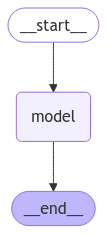

In [5]:
from langchain_core.runnables import RunnableConfig, RunnableLambda
from langchain_core.callbacks.manager import adispatch_custom_event


async def my_node(state: MessagesState, config: RunnableConfig):
    chunks = [
        "Four",
        "score",
        "and",
        "seven",
        "years",
        "ago",
        "our",
        "fathers",
        "...",
    ]
    for chunk in chunks:
        await adispatch_custom_event(
            "my_custom_event",
            {"chunk": chunk},
            config=config,  # <-- propagate config
        )

    return {"messages": [AIMessage(content=" ".join(chunks))]}


# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("model", my_node)
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

app = workflow.compile()

app

## Stream content

In [6]:
from langchain_core.messages import HumanMessage

inputs = [HumanMessage(content="What are you thinking about?")]
async for event in app.astream_events({"messages": inputs}, version="v2"):
    tags = event.get("tags", [])
    if event["event"] == "on_custom_event" and event["name"] == "my_custom_event":
        data = event["data"]
        if data:
            print(data["chunk"], end="|", flush=True)

Four|score|and|seven|years|ago|our|fathers|...|